In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

stock = yf.Ticker("GOOG")

In [43]:
df = yf.download(tickers="GOOG", period="1d", interval="1m")
stock.history(period='1d', interval="1m")
print(df.head())

[*********************100%***********************]  1 of 1 completed
                           Open        High         Low       Close  \
Datetime                                                              
2023-10-24 09:30:00  139.160004  139.369995  138.750000  139.369995   
2023-10-24 09:31:00  139.364807  139.449997  139.179993  139.240005   
2023-10-24 09:32:00  139.259995  139.279999  138.970001  138.970001   
2023-10-24 09:33:00  138.960007  139.250000  138.839996  139.208298   
2023-10-24 09:34:00  139.259995  139.529999  139.240005  139.447998   

                      Adj Close  Volume  
Datetime                                 
2023-10-24 09:30:00  139.369995  748403  
2023-10-24 09:31:00  139.240005   76096  
2023-10-24 09:32:00  138.970001  118376  
2023-10-24 09:33:00  139.208298   70437  
2023-10-24 09:34:00  139.447998   80998  


In [44]:
#df = stock.history(period='7d', interval="1m")
df = df[["Open", "High", "Low", "Close", "Volume"]]
df.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-10-24 09:30:00,139.160004,139.369995,138.750000,139.369995,748403
2023-10-24 09:31:00,139.364807,139.449997,139.179993,139.240005,76096
2023-10-24 09:32:00,139.259995,139.279999,138.970001,138.970001,118376
2023-10-24 09:33:00,138.960007,139.250000,138.839996,139.208298,70437
2023-10-24 09:34:00,139.259995,139.529999,139.240005,139.447998,80998


In [45]:
X = df.index.values
y = df['Low'].values# The split point is the 10% of the dataframe length
offset = 6          # Number of candles in a day

X_train = X[:-offset]
y_train = y[:-offset]
X_test  = X[-offset:]
y_test  = y[-offset:]

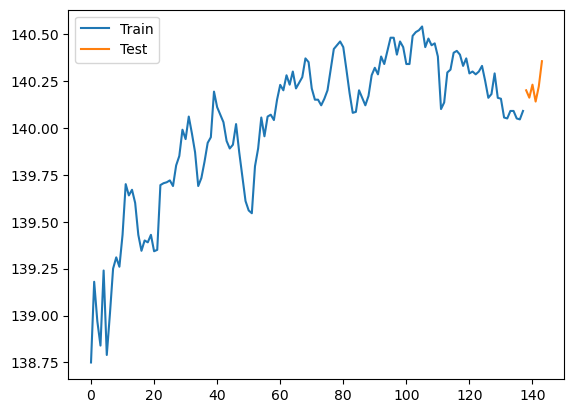

In [46]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(y_train)),y_train, label='Train')
plt.plot(range(len(y_train),len(y)),y_test,label='Test')
plt.legend()
plt.show()

In [47]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(5,0,1)).fit()
forecast = model.forecast(steps=6)[0]

In [48]:
test_pred = model.forecast(steps=6)

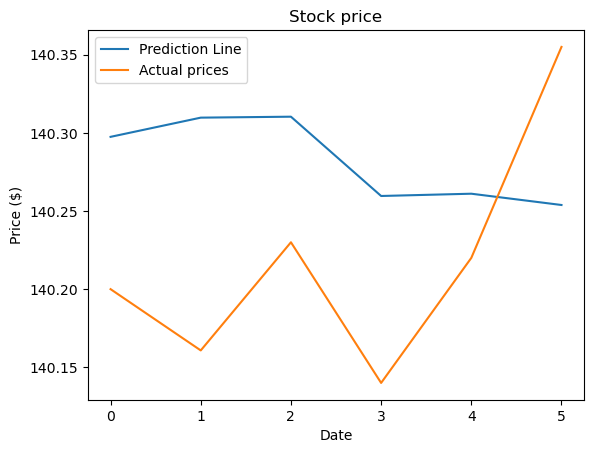

In [49]:
# Visualize the predictions
# demo.plot(forecast[:3300])
plt.plot(test_pred, label="Prediction Line")
plt.plot(y_test, label="Actual prices")
plt.legend()
plt.title("Stock price")

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

In [50]:
print("RMSE of Prophet is: ", np.sqrt(np.mean(np.array(test_pred-y_test)**2)))
print("MAE of Prophet is: ", mean_absolute_error(y_test, test_pred))

RMSE of Prophet is:  0.10357337234067773
MAE of Prophet is:  0.09809795567376038


In [59]:
from backtesting import Backtest
from backtesting.lib import TrailingStrategy, crossover

class ARIMA_model(TrailingStrategy):
    def init(self):
        super().init()
        self.set_trailing_sl(3)
        self.cnt = 5

    def next(self):
        super().next()
        self.cnt += 1

        if self.cnt>=5:
            self.cnt = 0
            self.y = self.data.Low
            model = ARIMA(self.y, order=(5,0,1)).fit()
            self.forecast = model.forecast(steps=7)

        if self.data.Close[-1]<self.forecast[self.cnt]:
            self.buy(size=0.6)
        if self.data.Close[-1]>self.forecast[self.cnt]:
            self.sell(size=0.6)

In [60]:
bt = Backtest(df, ARIMA_model,
            cash=100000, trade_on_close=False, exclusive_orders=True)

stats = bt.run()

In [61]:
import numpy as np

print("OC-Range: ", (df["Close"].iloc[-1]-df["Close"].iloc[0])/df["Close"].iloc[0])
print("HL-Range: ", (np.max(df["Close"])-np.min(df["Close"]))/np.min(df["Close"]))

OC-Range:  0.007067522744212893
HL-Range:  0.011873022105425199


In [62]:
stats

Start                     2023-10-24 09:30:00
End                       2023-10-24 11:53:00
Duration                      0 days 02:23:00
Exposure Time [%]                   98.611111
Equity Final [$]                 99950.055527
Equity Peak [$]                 100340.473953
Return [%]                          -0.049944
Buy & Hold Return [%]                0.706752
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.468487
Avg. Drawdown [%]                   -0.263522
Max. Drawdown Duration        0 days 02:18:00
Avg. Drawdown Duration        0 days 01:10:00
# Trades                                  142
Win Rate [%]                        46.478873
Best Trade [%]                       0.258184
Worst Trade [%]                     -0.356564
Avg. Trade [%]                    